In [1]:
import numpy as np
from qiskit import *
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.tools.visualization import plot_histogram
from random import randint

[[-1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


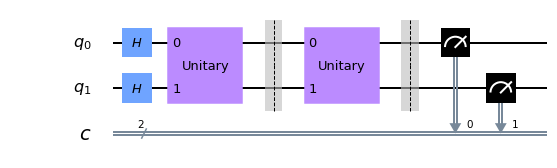

In [2]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.h(1)

# creating a randomized Grover operator
a = randint(0,3)
A = np.identity(4)
A[a,a] = -1
print(A)
Grov = Operator(A)
qc.append(Grov,[0,1])

qc.barrier()
# defining the operator to implement inversion about the mean
MeanInv = 0.5*np.ones((4,4),float)
np.fill_diagonal(MeanInv,-0.5)
MeanInv = Operator(MeanInv)
qc.append(MeanInv,[0,1])

qc.barrier()
qc.measure([0,1],[0,1])
qc.draw(output='mpl')

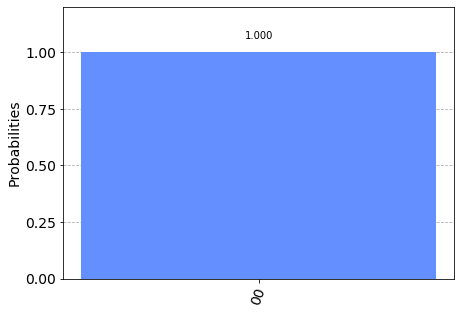

In [3]:
#simulate on qiskit aer
sim = Aer.get_backend('qasm_simulator')
res = execute(qc, backend = sim, shots = 1024).result()
simcounts = res.get_counts()

#writing something to plot the simulation results on a histogram
plot_histogram(res.get_counts(qc))

In [4]:
#running on a real quantum device
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_ourense')
job = execute(qc, backend=qcomp)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


The run counts are: {'01': 24, '00': 958, '10': 34, '11': 8}


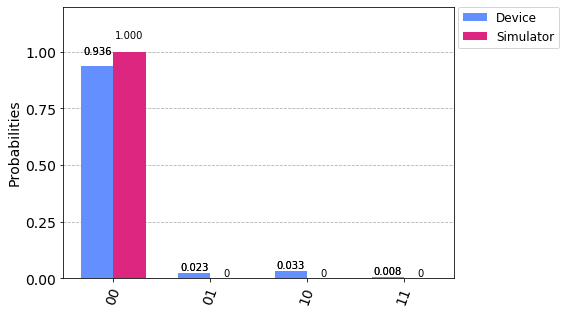

In [5]:
#plotting the results of the real computation
qres = job.result()
qcounts = qres.get_counts()
print('The run counts are:', counts)
plot_histogram([qcounts, simcounts], legend=['Device', 'Simulator'])

Job Status: job has successfully run


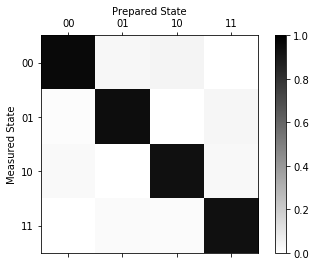

In [6]:
#noise mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

cal_circuits, state_labels = complete_meas_cal(qr = qc.qregs[0], circlabel = 'measerrormitcal')
cal_job = execute(cal_circuits,
                 backend = qcomp,
                 shots = 1024,
                 optimization_level = 0,
                 )

#this part runs the predefined calibration circuits for the circuit size and monitors the job
job_monitor(cal_job)
calres = cal_job.result()

#we use the calibration result to filter out our noisy results
meas_fitter = CompleteMeasFitter(calres, state_labels)

#filtering out noise from the quantum result
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter
mitres = meas_filter.apply(qres)

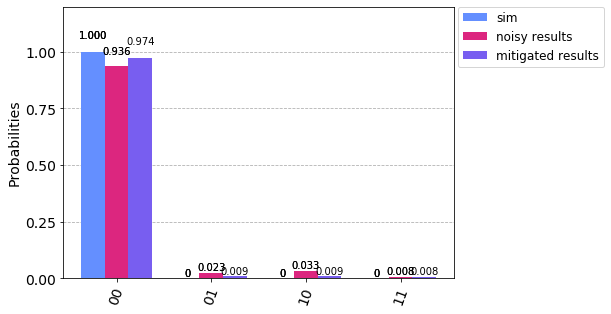

In [7]:
#plotting the sim vs noisy results vs mitigated results
mitcounts = mitres.get_counts(qc)
plot_histogram([simcounts, qcounts, mitcounts], 
               legend = ['sim', 'noisy results', 'mitigated results'])